In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import h5py

from tqdm import tqdm_notebook as tqdm
import warnings
warnings.filterwarnings('ignore')

def PCF(CM):
    pre = np.zeros(4)
    rec = np.zeros(4)
    f1 = np.zeros(4)
    n_items = np.zeros(4)
    for i in range(4):
        pre[i] = CM[i][i]/sum(CM[i])
        rec[i] = CM[i][i]/sum(CM.T[i])
        n_items[i] = sum(CM.T[i])
        f1[i] = 2*pre[i]*rec[i]/(pre[i]+rec[i])
    f1 = np.nan_to_num(f1)
    # El orden en los arrays de 4 es: peak, fila, sheet, void
    return pre, rec, f1, n_items

In [2]:
def compute_F1(method="Forest"):
    filename = 'features_prediction_'+str(method)+'_border.hdf5'
    f = h5py.File(filename, 'r')
    print(f.keys())
    data = {}
    for k in f.keys():
        data[k] = f[k][...]
    f.close()

    C = data['C']
    F1_av = data['F1']
    F1_peak = data['F1_peak']
    F1_fila = data['F1_fila']
    F1_sheet = data['F1_sheet']
    F1_void = data['F1_void']

    F1_weighted = np.ones(len(C))
    F1_av_no_voids = np.ones(len(C))
    for i in range(len(C)):
        p,r, f1, n_items = PCF(C[i])
        F1_weighted[i] = np.sum(f1*n_items)/np.sum(n_items)
        F1_av_no_voids[i] = np.mean(f1[0:3])
        if data['F1'][i] != np.mean(f1):
            print(data[i]['F1'])
            print(np.mean(f1),end="\n\n")
        if data['F1_peak'][i]!= f1[0]:
            print(data[i]['F1_peak'])
            print(f1[0],end="\n\n")
    columna = {"Forest":"NE", "Tree":"MD", "SVM":"MI"}
    return {'F1_av': F1_av, 'F1_av_no_voids':F1_av_no_voids, 'F1_weighted':F1_weighted, 
            'R':data['R'], 'S':data['S'], 'L':data['L'], 'NP': data[columna[method]]}

In [3]:
F1 = {}
methods = ["Forest", "Tree", "SVM"]
for m in methods:
    F1[m] = compute_F1(method=m)
    

<KeysViewHDF5 ['AUC', 'C', 'F1', 'F1_fila', 'F1_peak', 'F1_sheet', 'F1_void', 'G', 'L', 'NE', 'R', 'S']>
<KeysViewHDF5 ['AUC', 'C', 'F1', 'F1_fila', 'F1_peak', 'F1_sheet', 'F1_void', 'G', 'L', 'MD', 'R', 'S']>
<KeysViewHDF5 ['AUC', 'C', 'F1', 'F1_fila', 'F1_peak', 'F1_sheet', 'F1_void', 'G', 'L', 'MI', 'R', 'S']>


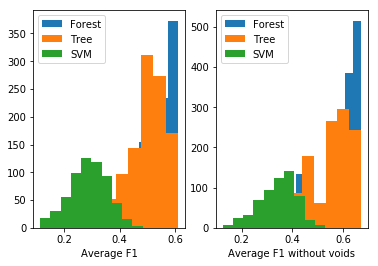

In [14]:

plt.subplot(1,2,1)
for m in ["Forest","Tree", "SVM"]:
    _=plt.hist(F1[m]["F1_av"], label=m)
plt.xlabel("Average F1")
plt.legend()
    
plt.subplot(1,2,2)
for m in ["Forest","Tree", "SVM"]:
    _=plt.hist(F1[m]["F1_av_no_voids"], label=m)
plt.xlabel("Average F1 without voids")
plt.legend()


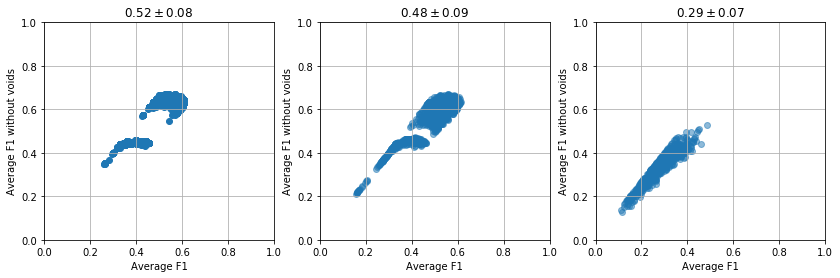

In [15]:
plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
plt.scatter(F1["Forest"]["F1_av"], F1["Forest"]["F1_av_no_voids"])
plt.xlabel("Average F1")
plt.ylabel("Average F1 without voids")
plt.xlim([0,1])
plt.ylim([0,1])
plt.title("${:.2f}\pm{:.2f}$".format(np.mean(F1["Forest"]["F1_av"]), np.std(F1["Forest"]["F1_av"])))
plt.grid()

plt.subplot(1,3,2)
plt.scatter(F1["Tree"]["F1_av"], F1["Tree"]["F1_av_no_voids"], alpha=0.5)
plt.title("${:.2f}\pm{:.2f}$".format(np.mean(F1["Tree"]["F1_av"]), np.std(F1["Tree"]["F1_av"])))
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel("Average F1")
plt.ylabel("Average F1 without voids")
plt.grid()


plt.subplot(1,3,3)
plt.scatter(F1["SVM"]["F1_av"], F1["SVM"]["F1_av_no_voids"], alpha=0.5)
plt.title("${:.2f}\pm{:.2f}$".format(np.mean(F1["SVM"]["F1_av"]), np.std(F1["SVM"]["F1_av"])))
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel("Average F1")
plt.ylabel("Average F1 without voids")
plt.grid()

In [6]:
def plot_params(method="Forest", criterion="F1_av", n_best=10):
    plt.figure(figsize=(17,4))

    plt.subplot(1,5,1)
    best = np.argsort(F1[method][criterion])
    ii = best[-n_best:]
    _ = plt.hist(F1[method]["L"][ii])
    plt.xlabel("Lambda")

    plt.subplot(1,5,2)
    _ = plt.hist(F1[method]["S"][ii])
    plt.xlabel("Smooth")
    
    plt.subplot(1,5,3)
    _ = plt.hist(F1[method]["R"][ii])
    plt.xlabel("RMAG")

    plt.subplot(1,5,4)
    _ = plt.hist(F1[method]["NP"][ii])
    plt.xlabel("NPARAMS")
    
    plt.subplot(1,5,5)
    plt.title("${:.4f}\pm{:.4f}$".format(np.mean(F1[method][criterion][ii]), np.std(F1[method][criterion][ii])))
    _ = plt.hist(F1[method][criterion][ii])
    plt.xlabel("F1")

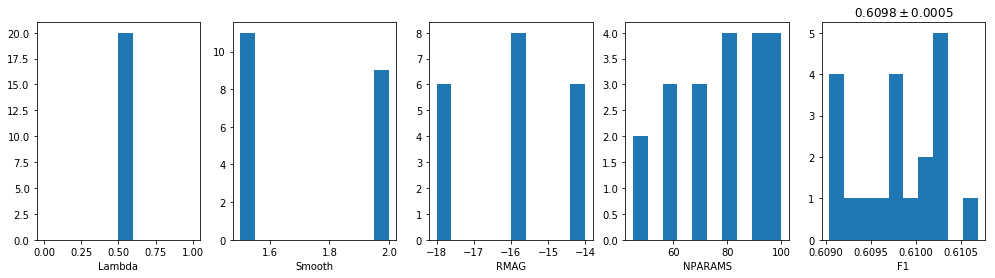

In [7]:
plot_params("Forest", n_best=20)

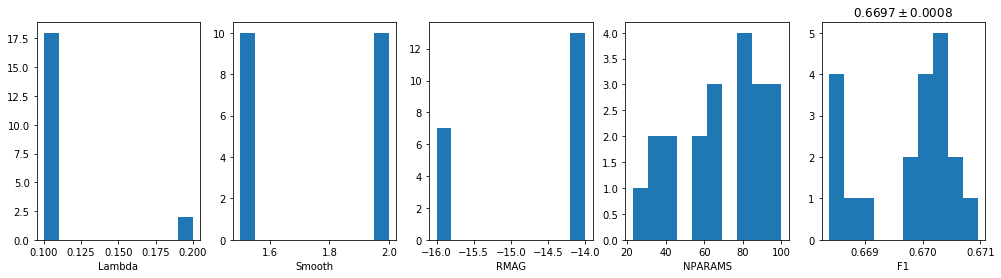

In [8]:
plot_params("Forest", criterion="F1_av_no_voids", n_best=20)

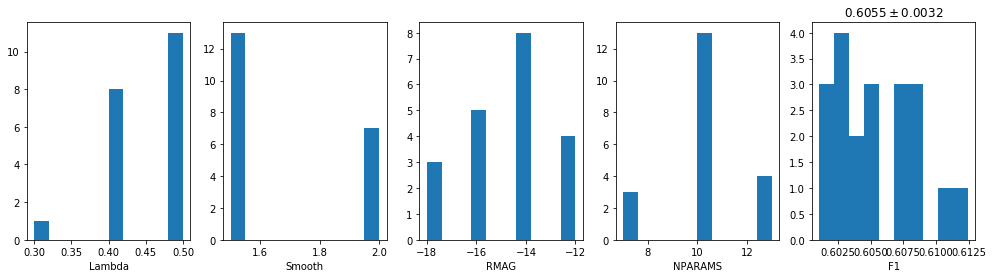

In [9]:
plot_params("Tree", n_best=20)

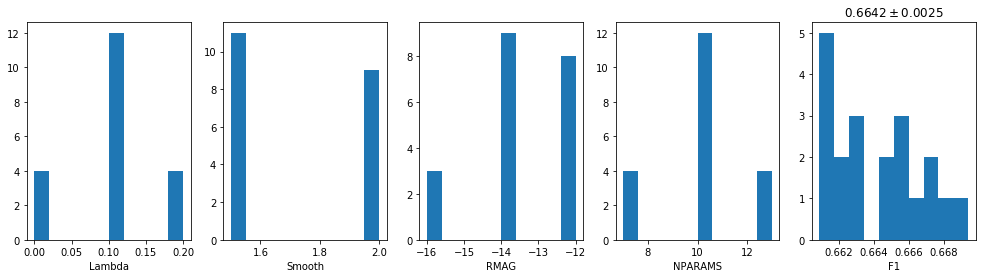

In [10]:
plot_params("Tree", criterion="F1_av_no_voids", n_best=20)

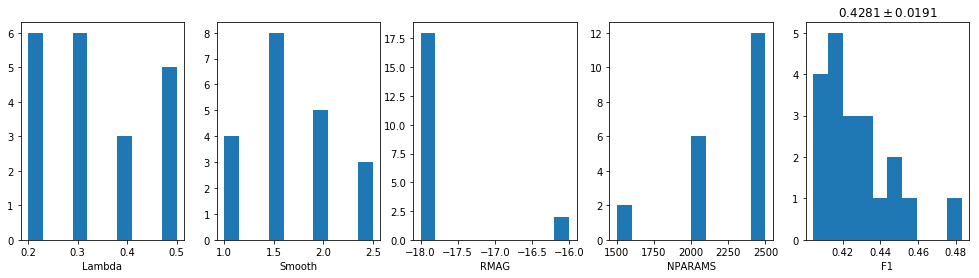

In [11]:
plot_params("SVM", n_best=20)

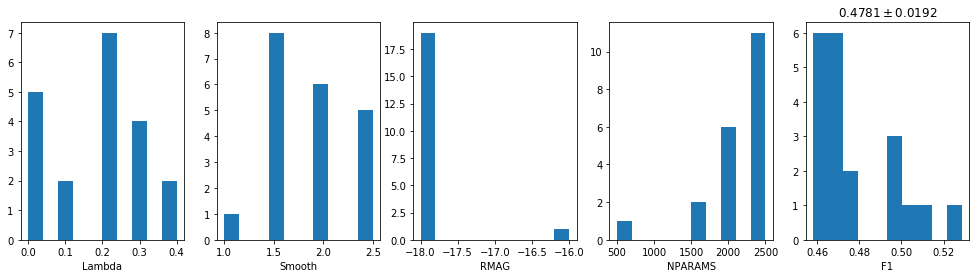

In [12]:
plot_params("SVM", criterion="F1_av_no_voids", n_best=20)